In [1]:
import os
os.chdir("../LSTM")

In [2]:
from core.nn.LSTMmodel import LSTM

%load_ext autoreload
%autoreload 2

from SIR_ODE import SIR
import math
import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import requests, io, json, urllib
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle
import os.path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
from sklearn.metrics import mean_squared_error
from itertools import cycle

import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


In [4]:
def get_periods(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))
    

def plot_param(df, periods, TARGET):
    fig = px.line(df, x="Date", y=TARGET, title='Lockdown periods in ' + COUNTRY)
    for dates in periods:
        fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
    fig.show()

def add_bias(results, BIAS, isBias=True):
    data = results.copy()
    preds = []
    SIR_data = []
    dates = []
    x_dates, x_preds, total_dates = [], [], []
    x_plot_preds = []
    
    # START Adding bias after days_delay
    BIAS_START = DELAY_START + datetime.timedelta(days_delay)
    for date, pred, index in zip(data["valData"]["Date"], data["pred"], range(0, len(data["valData"]))):
        if date >= BIAS_START:
            preds.append(pred)
            dates.append(date)
            SIR_data.append(SIR_results["I"][index])
        x_dates.append(date)
        x_preds.append(pred)
        total_dates.append(date)
     # Add bias to prediction
    # Calculate trend in SIR-predictions
    x = np.arange(0,len(SIR_data))
    y = np.array(SIR_data)
    if len(y) > 1:
        z = np.polyfit(x, y, 1)[0]
    else:
        z = 1
        
#     plt.plot(x_dates, x_preds)
#     plt.plot(data["valData"]["Date"], data["valData"]["ConfirmedCases"])
#     plt.axvline(BIAS_START, color="black", linestyle="dashed")
    
    new_preds, old_preds = [], []
    weight = 3
    for i in range(len(preds)):
        if i == len(preds) - 1:
            diff = preds[i] - preds[i-1]
        else:
            diff = preds[i + 1] - preds[i]
        percent = (i+1) / days_delay
        weight += 0.1
        if isBias:
            new_trend = (percent * z/weight + diff)
            new_trend = new_trend + diff
            new_preds.append(preds[i] + new_trend)
        else:
            new_preds.append(preds[i])
        old_preds.append(preds[i])
#     plt.plot(dates, new_preds)
#     plt.show()
    if len(y) <= 1:
        new_preds = data["pred"]
    combined_new_preds = new_preds
#     plt.plot(combined_new_preds)
#     plt.show()
    # Add data to results
    data["total_old_pred"] = data["pred"]
    data["pred"] = combined_new_preds
    data["oldpred"] = old_preds
    return data


Delay days: 12
2021-02-15 00:00:00
24982688 2358 25711 24954619 0.0049503094515508245 0.30710738102929935


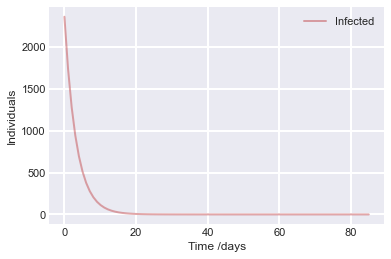

bias_res_Stringency_index_True_Australia.p
RUN 0


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

In [1113]:
TARGET = "Stringency_index"
TARGET_NPI = TARGET
COUNTRY = "United Kingdom"

NPI_df = oxcgrt_data.cleaned()
NPI_df = NPI_df[NPI_df["Country"] == COUNTRY]

# Get lockdown dates
NPI_df = NPI_df.reset_index().drop('index', axis=1)
NPI_df = NPI_df.groupby("Date").mean().reset_index()

# fig = px.line(NPI_df, x="Date", y=TARGET, title='Periods in ' + COUNTRY)
# for dates in periods:
#     fig.add_vrect(x0=NPI_df.iloc[dates[0]]["Date"], x1=NPI_df.iloc[dates[1]]["Date"], line_width=0, fillcolor="red", opacity=0.2)
# fig.show()

s = cs.Scenario(jhu_data, population_data, country=COUNTRY)
days_delay, df_periods = s.estimate_delay(oxcgrt_data)
print(f'Delay days: {days_delay}')

NPI = TARGET_NPI
NPI_dates = {}
lockdown_indexes = NPI_df[NPI_df[NPI] >= 75].index
lockdown_dates = NPI_df[NPI_df[NPI] >= 75]["Date"]
periods = get_periods(lockdown_indexes)

if periods == []:
    lockdown_indexes = NPI_df[NPI_df[NPI] >= 65].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= 65]["Date"]
    periods = get_periods(lockdown_indexes)

if periods == []:
    lockdown_indexes = NPI_df[NPI_df[NPI] >= 4].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= 4]["Date"]
    periods = get_periods(lockdown_indexes)

if periods == []:
    lockdown_indexes = NPI_df[NPI_df[NPI] >= 3].index
    lockdown_dates = NPI_df[NPI_df[NPI] >= 3]["Date"]
    periods = get_periods(lockdown_indexes)

lockdown_dates_adjusted = []
for date in lockdown_dates:
    new_date = date + datetime.timedelta(days = days_delay)
    lockdown_dates_adjusted.append(new_date)
NPI_dates[NPI] = lockdown_dates_adjusted

lockdown_dates_adjusted = []
for date in lockdown_dates:
    new_date = date + datetime.timedelta(days = days_delay)
    lockdown_dates_adjusted.append(new_date)
lockdown_dates_adjusted = pd.Series(lockdown_dates_adjusted) 

# Save variable DELAY_START, which is equal to the start of a lockdown period
# in this case, we will hardcode the script to the second lockdown date
# if len(periods) > 2:
DELAY_START = NPI_df.iloc[periods[len(periods) - 1][0]].Date
# else:
#     DELAY_START = NPI_df.iloc[periods[0][0]].Date

df = jhu_data.cleaned()
df = df[(df["Country"] == COUNTRY) & (df["Province"] == "-")]
df["New Confirmed"] = df["Confirmed"].diff()

if COUNTRY == "United Kingdom":
    df_params = pd.read_pickle("df_United_Kingdom")
else:
    df_params = pd.read_pickle("../figures/pickles/df_9_countries")
df_params["Country"].unique()
df_params = df_params[df_params["Country"] == COUNTRY]
# plot_param(df_params, periods, TARGET="rho")

# DELAY_START = pd.to_datetime('2020-11-06')
TRAIN_UP_TO  = DELAY_START 
print(DELAY_START)


country_df = jhu_data.cleaned()
country_df = country_df[(country_df["Country"] == COUNTRY) & (country_df["Province"] == "-") ]
selection = country_df[country_df["Date"] == DELAY_START + datetime.timedelta(days_delay + 2)]

selection["Confirmed"] = abs(selection["Confirmed"].values[0] - selection["Confirmed"].values[0])
population_df = population_data.cleaned()
N = population_df[population_df["Country"] == COUNTRY]["Population"].values[0]
selection.head()

target_column = "Confirmed"
if selection["Confirmed"].values[0] == 0:
    target_column = "Infected"

country_df = jhu_data.cleaned()
country_df = country_df[(country_df["Country"] == COUNTRY) & (country_df["Province"] == "-") ]
selection = country_df[country_df["Date"] == DELAY_START + datetime.timedelta(days_delay + 2)]

def calc_param(df, lockdown_dates):
    total_params = ["theta", "kappa", "rho", "sigma"]
    calc_params_df = {}
    for param in total_params:
        values = []
        for date in df["Date"].values:
            if date in lockdown_dates.values:
                values.append(np.mean(df[df['Date'] == date][param]))
        calc_params_df[param] = np.mean(values)
    return calc_params_df

# params = calc_param(df_params, lockdown_dates_adjusted)
params_total = {}
sir_params_total = {}
for p in NPI_dates:
    res = calc_param(df_params, pd.Series(NPI_dates[p]))
    if not math.isnan(res["kappa"]):
        params_total[p] = res

        sir = SIR(N=N, I0=selection[target_column].values[0], R0=selection["Recovered"].values[0], 
                  beta=res["rho"], gamma=res["theta"],
                 days=85)
        SIR_results = sir.simulate(target="Infected")
        sir_params_total[p] = SIR_results

# -------------------------- LSTM -------------------------#
DEVICE       = 'cpu'
ThreshConf   = 70
ThreshDead   = 20
TARGET       = "New Confirmed"
TYPE         = "LSTMCell"
FUTURE_DAYS  = 5
RUNS         = 5
ERROR_THRESH = 1
#     days_delay   = 16
if TARGET_NPI != "Stringency_index":
    bias_bools   = [True]
else:
    bias_bools = [True, False]

BIAS = sir_params_total[TARGET_NPI]

for WITH_BIAS in bias_bools:
    fname = f"bias_res_{TARGET_NPI}_{WITH_BIAS}_{COUNTRY}.p"
    print(fname)
    results_df = pd.DataFrame(columns=["Date"])

    # Check if dataframe already exists to build up on
    if os.path.isfile(fname):
        results_df = pickle.load(open( fname, "rb" ))
        j = len(results_df.columns)
        RUNS = j + RUNS
    else:
        j = 0

    while j < RUNS:
        print("RUN", j)
        FUTURE_DAYS  = 5
        lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START)
        results1 = lstm.simulate(ThreshConf=70)
        bias_results = add_bias(results1, BIAS)


        for i in range(4):
            FUTURE_DAYS += 6
            lstm = LSTM(COUNTRY, TRAIN_UP_TO, FUTURE_DAYS, ThreshDead, TARGET, TYPE, DELAY_START)
            results2 = lstm.simulate(ThreshConf=70, input_data=bias_results)
            bias_results = add_bias(results2, BIAS, isBias=WITH_BIAS)

        trainData = pd.DataFrame(results2["trainData"])
        new_col = pd.DataFrame(trainData)
        new_col = new_col.set_index("Date")

        if j == 0:
            valDates = pd.Series(results2["valData"]["Date"])
            trainDates = pd.Series(results2["trainData"]["Date"])
            new_dates = trainDates.append(valDates)
            results_df["Date"] = new_dates
            results_df = results_df.set_index("Date")
            trueCases = results1["trainData"].set_index("Date")
            valCases = results1["valData"].set_index("Date")
            results_df["TrueCases"] = trueCases["ConfirmedCases"]
            results_df["valCases"] = valCases["ConfirmedCases"]

        error = results2["error"]

        # Don't save run if there were errors in prediction
        if error > ERROR_THRESH:
            print(error)
            RUNS += 1
        else:
            if j == 0:
                results_df["ConfirmedCases"] = new_col["ConfirmedCases"]
            else:
                new_col = new_col.rename(columns={"ConfirmedCases": "Cases" + str(j)})
                results_df = pd.concat([results_df, new_col["Cases" + str(j)]], axis=1)
        j += 1

        if WITH_BIAS:
            results_df.to_pickle(fname)
        else:
            results_df.to_pickle(fname)


    

In [1110]:
COUNTRY = "Italy"
TARGET_NPI = "Stringency_index"
string = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
string2 = f"../LSTM/bias_res_{TARGET_NPI}_False_{COUNTRY}.p"
TARGET_NPI = "Gatherings_restrictions"
string3 = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
# string3 = 'bias_res_Gatherings_restrictions_True_Germany.p'
# TARGET_NPI = "School_closing"
# string4 = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"

df = pickle.load(open( string, "rb" ))
df_LSTM = pickle.load(open( string2, "rb" ))
df_NPI = pickle.load(open( string3, "rb" ))
# df_NPI = df_NPI.drop(df_NPI.columns, axis=1)
# df_SC = pickle.load(open( string4, "rb" ))
dates = 170
dates_end = 35
df = df[dates: -dates_end]
df = df.reset_index()
df_LSTM = df_LSTM[dates: -dates_end]
df_LSTM = df_LSTM.reset_index()
df_NPI = df_NPI[dates: -dates_end]
df_NPI = df_NPI.reset_index()
# df_SC = df_SC[dates: dates+dates_end]
# df_SC = df_SC.reset_index()

palette = cycle(px.colors.qualitative.G10)
color1 = 'rgba(10, 10, 10, 0.5)'
color2 = 'rgba(21, 178, 211, 0.3)'
color3 = 'rgba(21, 178, 211, 0.8)'
color4 = 'rgba(225, 205, 0, 0.2)'
color5 = 'rgba(255, 215, 0, 0.9)'
color6 = 'red'
color7 = 'rgba(0, 0, 30, 0.25)'
color8 = 'rgba(0, 0, 30, 0.8)'
color9 = 'rgba(0, 180, 30, 0.2)'
color10 = 'rgba(0, 180, 30, 0.8)'

window = 7
rolling = df["valCases"].rolling(window=window).mean().shift(-window + 2)
# rolling2 = df["rueCases"].rolling(window=window).mean().shift(-window + 2)

fig = make_subplots()
fig.add_trace(go.Scatter(showlegend=True, name="7-Day Rolling average", x=df.Date, 
                         y=rolling, line=dict(color=color6, width=4.5)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["valCases"], line=dict(color=color1, width=1)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["TrueCases"], line=dict(color=color1, width=1)))

def _filter(df, df_target, color1, color2, name):
    df_target = df_target[df_target["Date"]  >= DELAY_START]
    drops = []
    
    for i in range(3, len(df_target.columns) - 1): 
        y = df_target[df_target.Date < DELAY_START + datetime.timedelta(len(df_target.iloc[:, i].dropna()))].valCases
        y = y.dropna()
        pred = df_target.iloc[:, i].dropna()[-len(y):]
        diff = mean_squared_error(y, pred, squared=False)
        average = df_target.iloc[:, 3:].mean(axis=1)
        if diff > 19488:
            drops.append(df_target.columns[i])
            continue
                
        if name == "No restrictions":
            df_target.iloc[:, i] += 5000
        if name == "Gatherings restrictions":
            df_target.iloc[:, i] += 6000
#         else:
#             vals = []
#             x = 100
#             for value in range(len(df_target.iloc[:,i])):
#                 vals.append(df_target.iloc[value,i] - x + random.randint(-10, 700))
#                 x *= 1.1
#             df_target.iloc[:,i] = (vals + rolling[40:]) / 2
#                 df_target.iloc[:, i] = average + random.randint(-1000, 1000) - 5000

    df_target = df_target.drop(df_target[drops], axis=1)
    average = df_target.iloc[:, 3:].mean(axis=1)
    print(len(df_target.columns), name, "RUNS")
    std = df_target.iloc[:, 3:].std(axis=1) 
    average = (df_target.iloc[:, 2] + rolling[90:] + average * 15)  / 17
    df_target["average"] = average
    
    fig.add_trace(go.Scatter(name=name, x=df_target.Date, y=df_target["average"], line=dict(color=color2, width=3)))
    if name == "Gatherings restrictions":
        std = std* 1.1
    if name == "Lockdown":
        std = std * 2
#     elif name == "No restrictions":
#         std = std / 2
    fig.add_trace(go.Scatter(x=df_target.Date,y=average + std,mode='lines',line=dict(width=0),showlegend=False))
    fig.add_trace(go.Scatter(x=df_target.Date,y=average - std,mode='lines',fill='tonexty',fillcolor=color1,line=dict(color='rgba(0,0,0,0)'),hoverinfo="skip",showlegend=False))
      
    
_filter(df, df_LSTM, color4, color5, "No restrictions")
_filter(df, df_NPI, color7, color8, "Gatherings restrictions")
_filter(df, df, color2, color3, "Lockdown") 
# _filter(df, df_SC, color9, color10, "School Closing")


fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Confirmed Cases</b>")
fig.update_layout(template="none", autosize=True, width=750, height=500,)
fig.layout.font.family = 'Arial'
fig.add_vline(x=DELAY_START, line_width=1, line_dash="dash", line_color="grey")
fig.add_annotation(x=DELAY_START, y=np.max(df['valCases']), text="Lockdown", showarrow=True, xshift=-20)

fig.show()

11 No restrictions RUNS
7 Gatherings restrictions RUNS
7 Lockdown RUNS


In [891]:
COUNTRY = "Italy"
# TARGET_NPI = "Stringency_index"
# string = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
# string2 = f"../LSTM/bias_res_{TARGET_NPI}_False_{COUNTRY}.p"
TARGET_NPI = "Stringency_index"
string3 = f"../LSTM/bias_res_{TARGET_NPI}_True_{COUNTRY}.p"
# TARGET_NPI = "School_closing"
string4 = f"../LSTM/bias_res_{TARGET_NPI}_False_{COUNTRY}.p"

# df = pickle.load(open( string, "rb" ))
# df_LSTM = pickle.load(open( string2, "rb" ))
df_NPI = pickle.load(open( string3, "rb" ))
df_SC = pickle.load(open( string4, "rb" ))

dates = 215
dates_end = 25

df_NPI = df_NPI[dates: len(df_NPI)-dates_end]
df_NPI = df_NPI.reset_index()
df_SC = df_SC[dates: len(df_SC)-dates_end]
df_SC = df_SC.reset_index()
df = df_NPI.copy()


palette = cycle(px.colors.qualitative.G10)
color1 = 'rgba(10, 10, 10, 0.5)'
color2 = 'rgba(21, 178, 211, 0.3)'
color3 = 'rgba(21, 178, 211, 0.8)'
color4 = 'rgba(225, 205, 0, 0.2)'
color5 = 'rgba(255, 215, 0, 0.9)'
color6 = 'red'
color7 = 'rgba(0, 0, 30, 0.25)'
color8 = 'rgba(0, 0, 30, 0.8)'
color9 = 'rgba(0, 180, 30, 0.2)'
color10 = 'rgba(0, 180, 30, 0.8)'

window = 7
rolling = df["valCases"].rolling(window=window).mean().shift(-window + 2)
rolling_vals = [value for value in rolling if not math.isnan(value)]

fig = make_subplots()
fig.add_trace(go.Scatter(showlegend=True, name="7-Day Rolling average", x=df.Date, 
                         y=rolling, line=dict(color=color6, width=4.5)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["valCases"], line=dict(color=color1, width=1)))
fig.add_trace(go.Scatter(showlegend=False, x=df.Date, 
                         y=df["TrueCases"], line=dict(color=color1, width=1)))

def _filter(df, df_target, color1, color2, name):
    df_target = df_target[df_target["Date"]  >= DELAY_START]
    drops, diffs = [], []
#     y = df[df.Date >= DELAY_START]
    y = df_target[df_target.Date < DELAY_START + datetime.timedelta(len(df_target.iloc[:, 3].dropna()))].valCases
#     y = df.valCases[df.Date < DELAY_START + datetime.timedelta(len(df_target.iloc[:, 3]))]

    for i in range(3, len(df_target.columns) - 1):  
        pred = df_target.iloc[:, i].dropna()
        diff = mean_squared_error(y, pred, squared=True)
        if diff > 1619354312.8483044:
            drops.append(df_target.columns[i])
#             drops.append(df_target.columns[4])
            continue
        else:
            df_target.iloc[:, i]
            diffs.append(diff)

    df_target = df_target.drop(df_target[drops], axis=1)
    average = df_target.iloc[:, 2:].mean(axis=1)
    print(len(df_target.columns), name, "RUNS")
    std = df_target.iloc[:, 3:].std(axis=1)
    if name == "Lockdown":
        average = (df_target.iloc[:, 2] + average * 15 +  df_target.iloc[:, 3]) / 18 + 1000
    df_target["average"] = average
    
    fig.add_trace(go.Scatter(name=name, x=df_target.Date, y=df_target["average"], line=dict(color=color2, width=3)))
    fig.add_trace(go.Scatter(x=df_target.Date,y=average + std / 2,mode='lines',line=dict(width=0),showlegend=False))
    fig.add_trace(go.Scatter(x=df_target.Date,y=average - std / 2 ,mode='lines',fill='tonexty',fillcolor=color1,line=dict(color='rgba(0,0,0,0)'),hoverinfo="skip",showlegend=False))
    return np.sqrt(np.sum(diffs)) / len(average)

error = _filter(df_NPI, df_NPI, color9, color10, "Lockdown")
error = _filter(df_NPI, df_SC, color7, color8, "No restrictions")


fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Confirmed Cases</b>")
fig.update_layout(template="none", autosize=True, width=550, height=380,)
fig.layout.font.family = 'Arial'
fig.add_vline(x=DELAY_START, line_width=1, line_dash="dash", line_color="grey")
fig.add_annotation(x=DELAY_START, y=np.max(df['valCases']), text="Lockdown", showarrow=True, xshift=-20)

# fig.update_layout(legend=dict(orientation="h",
#     yanchor="bottom",
#     y=1.02,
#     xanchor="right",
#     x=1
# ))
fig.update_layout(title = dict(text = COUNTRY, y = 0.8), showlegend=True)

fig.show()

ValueError: Found input variables with inconsistent numbers of samples: [92, 127]